## Example for training Spiking MLP on subset of NMNIST digits
### The problem:
Training digit classifier(0-9) on a subset(1000 training and 100 testing) of NMNIST digit spikes recorded using DVS camera. Just chagne the training and testing list for full NMNIST training.

## Load proper paths for SLAYER Pytorch source modules¶

In [1]:
import sys, os
CURRENT_TEST_DIR = os.getcwd()
sys.path.append(CURRENT_TEST_DIR + "/../../src")

## Load required modules
* SLAYER modules are available as `snn`.{`layer`, `params`, `loss`, `predict`, `io`}
* SLAYER-Loihi module implements `spikeLayer` (defines custom Loihi neuron behaviour) and `quantizeWeights` (defines weight quantization scheme)
* Optimizer implements custom NADAM optimizer

In [2]:
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader
import slayerSNN as snn
from slayerSNN import loihi as spikeLayer
from slayerSNN import quantize as quantizeParams
from slayerSNN import learningStats as learningStats
from slayerSNN import optimizer as optimizer
# from slayerLoihi import spikeLayer
# from quantizeParams import quantizeWeights
# from learningStats import learningStats
# import optimizer
import zipfile

## Read SNN configuration from yaml file

See the file for all the configuration parameters. This configuration file will be used to describe the SNN. The network configuration file (`network.yaml`) looks like this:

```python
simulation:
    Ts: 1.0
    tSample: 350
neuron:
    type:     LOIHI
    vThMant:  80 # 5
    vDecay:   128
    iDecay:   1024
    refDelay: 1
    wgtExp:   0
    tauRho:   1     # relative to theta 
    scaleRho: 1
training:
    error:
        type: NumSpikes #ProbSpikes #NumSpikes
        tgtSpikeRegion: {start: 0, stop: 300}   # only valid for NumSpikes and ProbSpikes
        tgtSpikeCount: {true: 60, false: 10}    # only valid for NumSpikes
    path:
        in:      NMNISTsmall/
        train:   NMNISTsmall/train1K.txt
        test:    NMNISTsmall/test100.txt
```     
Just change the path fields for full NMNIST training

In [3]:
netParams = snn.params('network.yaml')

## Extract NMNISTsmall dataset
This is a subset of NMNIST dataset containing first 1000 training samples and first 100 testing samples. The original NMNSIT dataset consists of full MNIST samples converted into spikes using DVS sensor moved in three repeatable saccadic motion. For details and full dataset download links, refer to [https://www.garrickorchard.com/datasets/n-mnist](https://www.garrickorchard.com/datasets/n-mnist)

In [4]:
with zipfile.ZipFile('NMNISTsmall.zip') as zip_file:
    for member in zip_file.namelist():
        if not os.path.exists('./' + member):
            zip_file.extract(member, './')

## Dataset Definition
The dataset definition follows standard PyTorch dataset definition. Internally, it utilizes `snn.io` modules to read spikes and returns the spike in correct tensor format (`CHWT`).
* `datasetPath`: the path where the spike files are stored.
* `sampleFile`: the file that contains a list of sample indices and its corresponding clases.
* `samplingTime`: the sampling time (in ms) to bin the spikes.
* `sampleLength`: the length of the sample (in ms)

Note: This is a simple dataset class. A dataset that utilizes the folder hierarchy or xml list is easy to create just like any other PyTorch dataset definition.

In [5]:
class nmnistDataset(Dataset):
    def __init__(self, datasetPath, sampleFile, samplingTime, sampleLength):
        self.path = datasetPath 
        self.samples = np.loadtxt(sampleFile).astype('int')
        self.samplingTime = samplingTime
        self.nTimeBins    = int(sampleLength / samplingTime)

    def __getitem__(self, index):
        # Read inoput and label
        inputIndex  = self.samples[index, 0]
        classLabel  = self.samples[index, 1]
        # Read input spike
        inputSpikes = snn.io.read2Dspikes(
                        self.path + str(inputIndex.item()) + '.bs2'
                        ).toSpikeTensor(torch.zeros((2,34,34,self.nTimeBins)),
                        samplingTime=self.samplingTime)
        # Create one-hot encoded desired matrix
        desiredClass = torch.zeros((10, 1, 1, 1))
        desiredClass[classLabel,...] = 1
        # Input spikes are reshaped to ignore the spatial dimension and the neurons are placed in channel dimension.
        # The spatial dimension can be maintained and used as it is.
        # It requires different definition of the dense layer.
        return inputSpikes.reshape((-1, 1, 1, inputSpikes.shape[-1])), desiredClass, classLabel
    
    def __len__(self):
        return self.samples.shape[0]

## Define the network
The network definition follows similar style as standard PyTorch network definition, but it utilizes snn modules.

In [6]:
class Network(torch.nn.Module):
    def __init__(self, netParams):
        super(Network, self).__init__()
        # initialize slayer
        slayer = spikeLayer(netParams['neuron'], netParams['simulation'])
        self.slayer = slayer
        # define network functions
        self.fc1   = slayer.dense((34*34*2), 512)
        self.fc2   = slayer.dense(512, 10)

    def forward(self, spikeInput):
        spike = self.slayer.spikeLoihi(self.fc1(spikeInput))
        spike = self.slayer.delayShift(spike, 1)
        # A minimum axonal delay of 1 tick is required in Loihi hardare
        spike = self.slayer.spikeLoihi(self.fc2(spike))
        spike = self.slayer.delayShift(spike, 1)
        return spike

## Initialize the network
* Define the device to run the code on.
* Create network instance.
* Create loss instance.
* Define optimizer module.
* Define training and testing dataloader.
* Cereate instance for learningStats.

In [7]:
# Define the cuda device to run the code on.
device = torch.device('cuda')

# Create network instance.
net = Network(netParams).to(device)

# Create snn loss instance.
error = snn.loss(netParams, spikeLayer).to(device)

# Define optimizer module.
# optimizer = torch.optim.Adam(net.parameters(), lr = 0.01, amsgrad = True)
optimizer = optimizer.Nadam(net.parameters(), lr = 0.01, amsgrad = True)

# Dataset and dataLoader instances.
trainingSet = nmnistDataset(datasetPath =netParams['training']['path']['in'], 
                            sampleFile  =netParams['training']['path']['train'],
                            samplingTime=netParams['simulation']['Ts'],
                            sampleLength=netParams['simulation']['tSample'])
trainLoader = DataLoader(dataset=trainingSet, batch_size=12, shuffle=False, num_workers=4)

testingSet = nmnistDataset(datasetPath  =netParams['training']['path']['in'], 
                            sampleFile  =netParams['training']['path']['test'],
                            samplingTime=netParams['simulation']['Ts'],
                            sampleLength=netParams['simulation']['tSample'])
testLoader = DataLoader(dataset=testingSet, batch_size=12, shuffle=False, num_workers=4)

# Learning stats instance.
stats = learningStats()

Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi
Max PSP kernel: 195.0
Scaling neuron[scaleRho] by Max PSP Kernel @slayerLoihi


## Visualize the spike data
Visualize the first five samples of the dataset.

`snn.io.showTD` should show an animation of the sequence in normal python session.

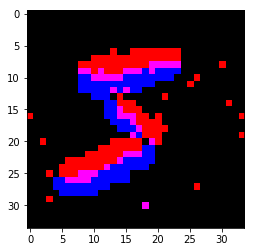

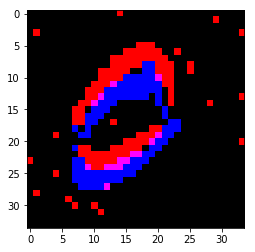

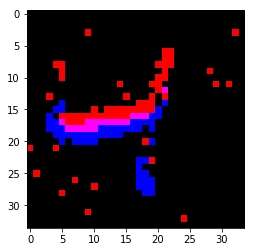

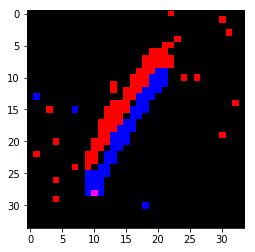

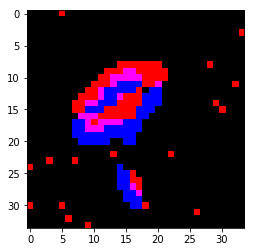

In [8]:
# Visualize the input spikes (first five samples).
for i in range(5):
    input, target, label = trainingSet[i]
    snn.io.showTD(snn.io.spikeArrayToEvent(input.reshape((2, 34, 34, -1)).cpu().data.numpy()))

## Train the network
* Train the network for 100 epochs.
* Best network is stored for inferencing later

In [9]:
for epoch in range(100):
    tSt = datetime.now()

    # Training loop.
    for i, (input, target, label) in enumerate(trainLoader, 0):
        # Move the input and target to correct GPU.
        input  = input.to(device)
        target = target.to(device) 

        # Forward pass of the network.
        output = net.forward(input)

        # Gather the training stats.
        stats.training.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
        stats.training.numSamples     += len(label)

        # Calculate loss.
        loss = error.numSpikes(output, target)

        # Reset gradients to zero.
        optimizer.zero_grad()

        # Backward pass of the network.
        loss.backward()

        # Update weights.
        optimizer.step()

        # Gather training loss stats.
        stats.training.lossSum += loss.cpu().data.item()

        # Display training stats. (Suitable for normal python implementation)
        # if i%10 == 0: stats.print(epoch, i, (datetime.now() - tSt).total_seconds())

    # Testing loop.
    # Same steps as Training loops except loss backpropagation and weight update.
    for i, (input, target, label) in enumerate(testLoader, 0):
        input  = input.to(device)
        target = target.to(device) 

        output = net.forward(input)

        stats.testing.correctSamples += torch.sum( snn.predict.getClass(output) == label ).data.item()
        stats.testing.numSamples     += len(label)

        loss = error.numSpikes(output, target)
        stats.testing.lossSum += loss.cpu().data.item()
        # if i%10 == 0:	stats.print(epoch, i)

    # Update testing stats.
    if epoch%10==0:  stats.print(epoch, timeElapsed=(datetime.now() - tSt).total_seconds())
    stats.update()
    if stats.training.bestLoss is True: torch.save(net.state_dict(), 'Trained/nmnistNet.pt')


Epoch :          0,    3389.0990 ms elapsed
loss = 12448                              	accuracy = 0.111                        
loss = 6.9844                             	accuracy = 0.13                         

Epoch :         10,    3184.6090 ms elapsed
loss = 1.8495       (min = 401.55      )  	accuracy = 0.841      (max = 0.802     )
loss = 8113.3       (min = 3.3527      )  	accuracy = 0.74       (max = 0.74      )

Epoch :         20,    3023.7330 ms elapsed
loss = 412.12       (min = 1.3214      )  	accuracy = 0.9        (max = 0.911     )
loss = 2.5671       (min = 2.4299      )  	accuracy = 0.77       (max = 0.79      )

Epoch :         30,    3230.1900 ms elapsed
loss = 0.96338      (min = 0.99635     )  	accuracy = 0.95       (max = 0.947     )
loss = 2.1362       (min = 2.2019      )  	accuracy = 0.83       (max = 0.83      )

Epoch :         40,    2974.8840 ms elapsed
loss = 0.78975      (min = 0.81585     )  	accuracy = 0.978      (max = 0.973     )
loss = 1.967       

## Plot the Results

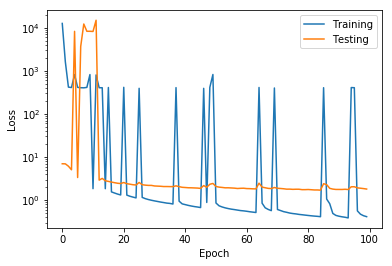

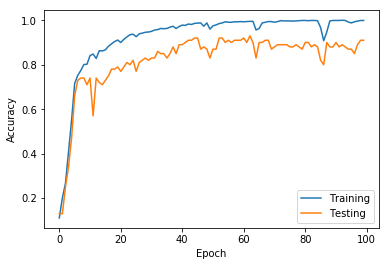

In [11]:
# Plot the results.
# Learning loss
plt.figure(1)
plt.semilogy(stats.training.lossLog, label='Training')
plt.semilogy(stats.testing .lossLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Learning accuracy
plt.figure(2)
plt.plot(stats.training.accuracyLog, label='Training')
plt.plot(stats.testing .accuracyLog, label='Testing')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Save training statistics

In [12]:
stats.save('Trained/')

## Generate Loihi parameters
Generate Loihi parameters i.e. weight files.

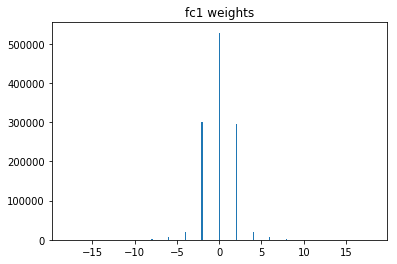

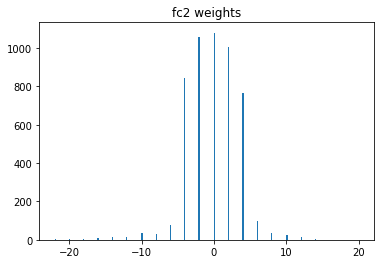

In [13]:
net.load_state_dict(torch.load('Trained/nmnistNet.pt'))
fc1Weights = quantizeWeights.apply(net.fc1.weight, 2).flatten().cpu().data.numpy()
fc2Weights = quantizeWeights.apply(net.fc2.weight, 2).flatten().cpu().data.numpy()

np.save('Trained/NMNISTFc1.npy', fc1Weights)
np.save('Trained/NMNISTFc2.npy', fc2Weights)

plt.figure(11)
plt.hist(fc1Weights, 256)
plt.title('fc1 weights')

plt.figure(12)
plt.hist(fc2Weights, 256)
plt.title('fc2 weights')

plt.show()